In [9]:
!pip install pandas numpy scikit-learn matplotlib seaborn tensorflow keras


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# ---- Load Dataset ----
df = pd.read_csv("datasets/motor_dataset_consistent.csv")

# Features & Targets
X = df[[
    "PhaseA_Current", "PhaseB_Current", "PhaseC_Current",
    "Power_Consumption", "Power_Factor",
    "Vibration", "Temp", "Speed"
]].values

y_cls = df["Health_Status"]
y_rul = df["RUL"]

# Encode classification labels
le = LabelEncoder()
y_cls = le.fit_transform(y_cls)

# ---- Alternate Row Split ----
X_train, X_test = X[::2], X[1::2]
y_cls_train, y_cls_test = y_cls[::2], y_cls[1::2]
y_rul_train, y_rul_test = y_rul[::2], y_rul[1::2]

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# For deep learning ‚Üí reshape for sequence input
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Input shape: {X_train_seq.shape}")  # Debug info

# ---- Classical ML Models ----
classifiers = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(solver='svd'),
    "Lasso": Lasso(max_iter=10000),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# ---- Evaluation Functions ----
def evaluate_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")
    return acc, f1

def evaluate_regressor(model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        return mae, rmse, r2
    except Exception as e:
        print(f"Error with {model.__class__.__name__}: {e}")
        return np.nan, np.nan, np.nan

# ---- Compare Classical Models ----
results_cls = []
results_reg = []

print("\n=== Classical Models ===")
for name, clf in classifiers.items():
    acc, f1 = evaluate_classifier(clf, X_train, y_cls_train, X_test, y_cls_test)
    results_cls.append((name, acc, f1))
    print(f"[CLS] {name} ‚Üí Accuracy={acc:.3f}, F1={f1:.3f}")

for name, reg in regressors.items():
    mae, rmse, r2 = evaluate_regressor(reg, X_train, y_rul_train, X_test, y_rul_test)
    results_reg.append((name, mae, rmse, r2))
    print(f"[REG] {name} ‚Üí MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

# ---- Deep Learning Models ----
print("\n=== Deep Learning Models ===")

def build_lstm_classifier(input_shape, num_classes):
    m = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    return m

def build_gru_classifier(input_shape, num_classes):
    m = Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    return m

def build_cnn_classifier(input_shape, num_classes):
    m = Sequential([
        Conv1D(64, kernel_size=3, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])
    m.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    return m

def build_lstm_regressor(input_shape):
    m = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    m.compile(loss="mse", optimizer=Adam(0.001), metrics=["mae"])
    return m

def build_gru_regressor(input_shape):
    m = Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    m.compile(loss="mse", optimizer=Adam(0.001), metrics=["mae"])
    return m

def build_cnn_regressor(input_shape):
    m = Sequential([
        Conv1D(64, kernel_size=3, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(1)
    ])
    m.compile(loss="mse", optimizer=Adam(0.001), metrics=["mae"])
    return m

num_classes = len(np.unique(y_cls))
y_cls_train_cat = to_categorical(y_cls_train, num_classes=num_classes)
y_cls_test_cat = to_categorical(y_cls_test, num_classes=num_classes)

# Deep Learning Classifiers
dl_classifiers = {
    "LSTM": build_lstm_classifier((X_train_seq.shape[1], 1), num_classes),
    "GRU": build_gru_classifier((X_train_seq.shape[1], 1), num_classes),
    "CNN": build_cnn_classifier((X_train_seq.shape[1], 1), num_classes)
}

# Deep Learning Regressors
dl_regressors = {
    "LSTM": build_lstm_regressor((X_train_seq.shape[1], 1)),
    "GRU": build_gru_regressor((X_train_seq.shape[1], 1)),
    "CNN": build_cnn_regressor((X_train_seq.shape[1], 1))
}

# Train and evaluate DL classifiers
for name, model in dl_classifiers.items():
    print(f"Training DL_{name} classifier...")
    try:
        model.fit(X_train_seq, y_cls_train_cat, epochs=30, batch_size=16, verbose=0, validation_split=0.2)
        loss, acc = model.evaluate(X_test_seq, y_cls_test_cat, verbose=0)
        preds = model.predict(X_test_seq, verbose=0)
        preds_class = np.argmax(preds, axis=1)
        f1 = f1_score(y_cls_test, preds_class, average="weighted")
        results_cls.append((f"DL_{name}", acc, f1))
        print(f"[CLS] DL_{name} ‚Üí Accuracy={acc:.3f}, F1={f1:.3f}")
    except Exception as e:
        print(f"Error training DL_{name}: {e}")
        results_cls.append((f"DL_{name}", np.nan, np.nan))

# Train and evaluate DL regressors
for name, model in dl_regressors.items():
    print(f"Training DL_{name} regressor...")
    try:
        model.fit(X_train_seq, y_rul_train, epochs=30, batch_size=16, verbose=0, validation_split=0.2)
        preds = model.predict(X_test_seq, verbose=0).flatten()
        mae = mean_absolute_error(y_rul_test, preds)
        rmse = np.sqrt(mean_squared_error(y_rul_test, preds))
        r2 = r2_score(y_rul_test, preds)
        results_reg.append((f"DL_{name}", mae, rmse, r2))
        print(f"[REG] DL_{name} ‚Üí MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    except Exception as e:
        print(f"Error training DL_{name}: {e}")
        results_reg.append((f"DL_{name}", np.nan, np.nan, np.nan))

# ---- Create Comparison Plots ----
# Convert results to DataFrames
df_cls = pd.DataFrame(results_cls, columns=['Model', 'Accuracy', 'F1_Score'])
df_reg = pd.DataFrame(results_reg, columns=['Model', 'MAE', 'RMSE', 'R2_Score'])

# Filter out models with NaN values
df_cls_clean = df_cls.dropna()
df_reg_clean = df_reg.dropna()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Classification Accuracy
bars1 = axes[0, 0].bar(range(len(df_cls_clean)), df_cls_clean['Accuracy'])
axes[0, 0].set_title('Classification Models - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_xticks(range(len(df_cls_clean)))
axes[0, 0].set_xticklabels(df_cls_clean['Model'], rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Classification F1 Score
bars2 = axes[0, 1].bar(range(len(df_cls_clean)), df_cls_clean['F1_Score'])
axes[0, 1].set_title('Classification Models - F1 Score', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1 Score', fontsize=12)
axes[0, 1].set_xticks(range(len(df_cls_clean)))
axes[0, 1].set_xticklabels(df_cls_clean['Model'], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Regression MAE
bars3 = axes[1, 0].bar(range(len(df_reg_clean)), df_reg_clean['MAE'])
axes[1, 0].set_title('Regression Models - MAE', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('MAE', fontsize=12)
axes[1, 0].set_xticks(range(len(df_reg_clean)))
axes[1, 0].set_xticklabels(df_reg_clean['Model'], rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Regression R2 Score
bars4 = axes[1, 1].bar(range(len(df_reg_clean)), df_reg_clean['R2_Score'])
axes[1, 1].set_title('Regression Models - R¬≤ Score', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('R¬≤ Score', fontsize=12)
axes[1, 1].set_xticks(range(len(df_reg_clean)))
axes[1, 1].set_xticklabels(df_reg_clean['Model'], rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Additional detailed comparison plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Classification comparison
x_pos = np.arange(len(df_cls_clean))
width = 0.35
bars_acc = axes[0].bar(x_pos - width/2, df_cls_clean['Accuracy'], width, label='Accuracy', alpha=0.8)
bars_f1 = axes[0].bar(x_pos + width/2, df_cls_clean['F1_Score'], width, label='F1 Score', alpha=0.8)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Scores', fontsize=12)
axes[0].set_title('Classification Models Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(df_cls_clean['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regression comparison (MAE and RMSE)
x_pos = np.arange(len(df_reg_clean))
bars_mae = axes[1].bar(x_pos - width/2, df_reg_clean['MAE'], width, label='MAE', alpha=0.8)
bars_rmse = axes[1].bar(x_pos + width/2, df_reg_clean['RMSE'], width, label='RMSE', alpha=0.8)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Error Values', fontsize=12)
axes[1].set_title('Regression Models Error Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(df_reg_clean['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best models
print("\n" + "="*50)
print("BEST PERFORMING MODELS")
print("="*50)

if not df_cls_clean.empty:
    best_cls_acc = df_cls_clean.loc[df_cls_clean['Accuracy'].idxmax()]
    best_cls_f1 = df_cls_clean.loc[df_cls_clean['F1_Score'].idxmax()]
    print(f"\nüèÜ Best Classification (Accuracy): {best_cls_acc['Model']} - Accuracy: {best_cls_acc['Accuracy']:.3f}")
    print(f"üèÜ Best Classification (F1): {best_cls_f1['Model']} - F1 Score: {best_cls_f1['F1_Score']:.3f}")

if not df_reg_clean.empty:
    best_reg_mae = df_reg_clean.loc[df_reg_clean['MAE'].idxmin()]
    best_reg_r2 = df_reg_clean.loc[df_reg_clean['R2_Score'].idxmax()]
    print(f"üèÜ Best Regression (MAE): {best_reg_mae['Model']} - MAE: {best_reg_mae['MAE']:.3f}")
    print(f"üèÜ Best Regression (R¬≤): {best_reg_r2['Model']} - R¬≤ Score: {best_reg_r2['R2_Score']:.3f}")

# Print summary table
print("\n" + "="*80)
print("SUMMARY OF ALL MODELS")
print("="*80)
print("\nClassification Models:")
print("-" * 80)
for _, row in df_cls.iterrows():
    if pd.isna(row['Accuracy']):
        print(f"{row['Model']:20s} ‚Üí Failed to train")
    else:
        print(f"{row['Model']:20s} ‚Üí Accuracy: {row['Accuracy']:.3f}, F1: {row['F1_Score']:.3f}")

print("\nRegression Models:")
print("-" * 80)
for _, row in df_reg.iterrows():
    if pd.isna(row['MAE']):
        print(f"{row['Model']:20s} ‚Üí Failed to train")
    else:
        print(f"{row['Model']:20s} ‚Üí MAE: {row['MAE']:.3f}, RMSE: {row['RMSE']:.3f}, R¬≤: {row['R2_Score']:.3f}")

# Save results to CSV
df_cls.to_csv('classification_results.csv', index=False)
df_reg.to_csv('regression_results.csv', index=False)
print(f"\nResults saved to 'classification_results.csv' and 'regression_results.csv'")

Input shape: (5000, 8, 1)

=== Classical Models ===
[CLS] RandomForest ‚Üí Accuracy=0.999, F1=0.999
[CLS] GradientBoosting ‚Üí Accuracy=0.998, F1=0.999
[CLS] DecisionTree ‚Üí Accuracy=0.999, F1=0.999
[CLS] LogisticRegression ‚Üí Accuracy=0.999, F1=0.999
[CLS] NaiveBayes ‚Üí Accuracy=0.999, F1=0.999
[CLS] SVM ‚Üí Accuracy=0.999, F1=0.999
[CLS] KNN ‚Üí Accuracy=0.999, F1=0.999
[REG] RandomForest ‚Üí MAE=3.793, RMSE=28.887, R2=0.944
[REG] GradientBoosting ‚Üí MAE=4.311, RMSE=28.397, R2=0.946
[REG] DecisionTree ‚Üí MAE=4.834, RMSE=43.123, R2=0.876
[REG] LinearRegression ‚Üí MAE=51.200, RMSE=85.723, R2=0.508
[REG] Ridge ‚Üí MAE=52.223, RMSE=86.650, R2=0.497
[REG] Lasso ‚Üí MAE=54.687, RMSE=88.820, R2=0.472
[REG] SVR ‚Üí MAE=22.358, RMSE=103.003, R2=0.290
[REG] KNN ‚Üí MAE=5.519, RMSE=33.748, R2=0.924

=== Deep Learning Models ===


c:\Users\sakshita\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\sakshita\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training DL_LSTM classifier...
[CLS] DL_LSTM ‚Üí Accuracy=0.950, F1=0.926
Training DL_GRU classifier...
[CLS] DL_GRU ‚Üí Accuracy=0.950, F1=0.926
Training DL_CNN classifier...
[CLS] DL_CNN ‚Üí Accuracy=0.950, F1=0.926
Training DL_LSTM regressor...
[REG] DL_LSTM ‚Üí MAE=44.450, RMSE=115.541, R2=0.107
Training DL_GRU regressor...
[REG] DL_GRU ‚Üí MAE=43.930, RMSE=93.965, R2=0.409
Training DL_CNN regressor...
[REG] DL_CNN ‚Üí MAE=51.085, RMSE=131.376, R2=-0.155



BEST PERFORMING MODELS

üèÜ Best Classification (Accuracy): RandomForest - Accuracy: 0.999
üèÜ Best Classification (F1): DecisionTree - F1 Score: 0.999
üèÜ Best Regression (MAE): RandomForest - MAE: 3.793
üèÜ Best Regression (R¬≤): GradientBoosting - R¬≤ Score: 0.946

SUMMARY OF ALL MODELS

Classification Models:
--------------------------------------------------------------------------------
RandomForest         ‚Üí Accuracy: 0.999, F1: 0.999
GradientBoosting     ‚Üí Accuracy: 0.998, F1: 0.999
DecisionTree         ‚Üí Accuracy: 0.999, F1: 0.999
LogisticRegression   ‚Üí Accuracy: 0.999, F1: 0.999
NaiveBayes           ‚Üí Accuracy: 0.999, F1: 0.999
SVM                  ‚Üí Accuracy: 0.999, F1: 0.999
KNN                  ‚Üí Accuracy: 0.999, F1: 0.999
DL_LSTM              ‚Üí Accuracy: 0.950, F1: 0.926
DL_GRU               ‚Üí Accuracy: 0.950, F1: 0.926
DL_CNN               ‚Üí Accuracy: 0.950, F1: 0.926

Regression Models:
-----------------------------------------------------------

Input shape: (5000, 5, 1)

=== Classical Models ===
[CLS] RandomForest ‚Üí Accuracy=1.000, F1=1.000
[CLS] GradientBoosting ‚Üí Accuracy=1.000, F1=1.000
[CLS] DecisionTree ‚Üí Accuracy=1.000, F1=1.000
[CLS] LogisticRegression ‚Üí Accuracy=1.000, F1=1.000
[CLS] NaiveBayes ‚Üí Accuracy=1.000, F1=1.000
[CLS] SVM ‚Üí Accuracy=1.000, F1=1.000
[CLS] KNN ‚Üí Accuracy=1.000, F1=1.000
[REG] RandomForest ‚Üí MAE=20.253, RMSE=39.164, R2=0.930
[REG] GradientBoosting ‚Üí MAE=20.263, RMSE=38.406, R2=0.933
[REG] DecisionTree ‚Üí MAE=26.052, RMSE=53.004, R2=0.872
[REG] LinearRegression ‚Üí MAE=30.419, RMSE=43.997, R2=0.912
[REG] Ridge ‚Üí MAE=30.394, RMSE=43.996, R2=0.912
[REG] Lasso ‚Üí MAE=29.455, RMSE=44.817, R2=0.909
[REG] SVR ‚Üí MAE=23.044, RMSE=39.760, R2=0.928
[REG] KNN ‚Üí MAE=20.704, RMSE=40.260, R2=0.926
Training DL_LSTM classifier...


c:\Users\sakshita\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\sakshita\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CLS] DL_LSTM ‚Üí Accuracy=0.800, F1=0.733
Training DL_GRU classifier...
[CLS] DL_GRU ‚Üí Accuracy=0.800, F1=0.733
Training DL_CNN classifier...
[CLS] DL_CNN ‚Üí Accuracy=0.800, F1=0.733
Training DL_LSTM regressor...
[REG] DL_LSTM ‚Üí MAE=62.370, RMSE=110.763, R2=0.442
Training DL_GRU regressor...
[REG] DL_GRU ‚Üí MAE=61.806, RMSE=110.947, R2=0.440
Training DL_CNN regressor...
[REG] DL_CNN ‚Üí MAE=63.433, RMSE=114.665, R2=0.402


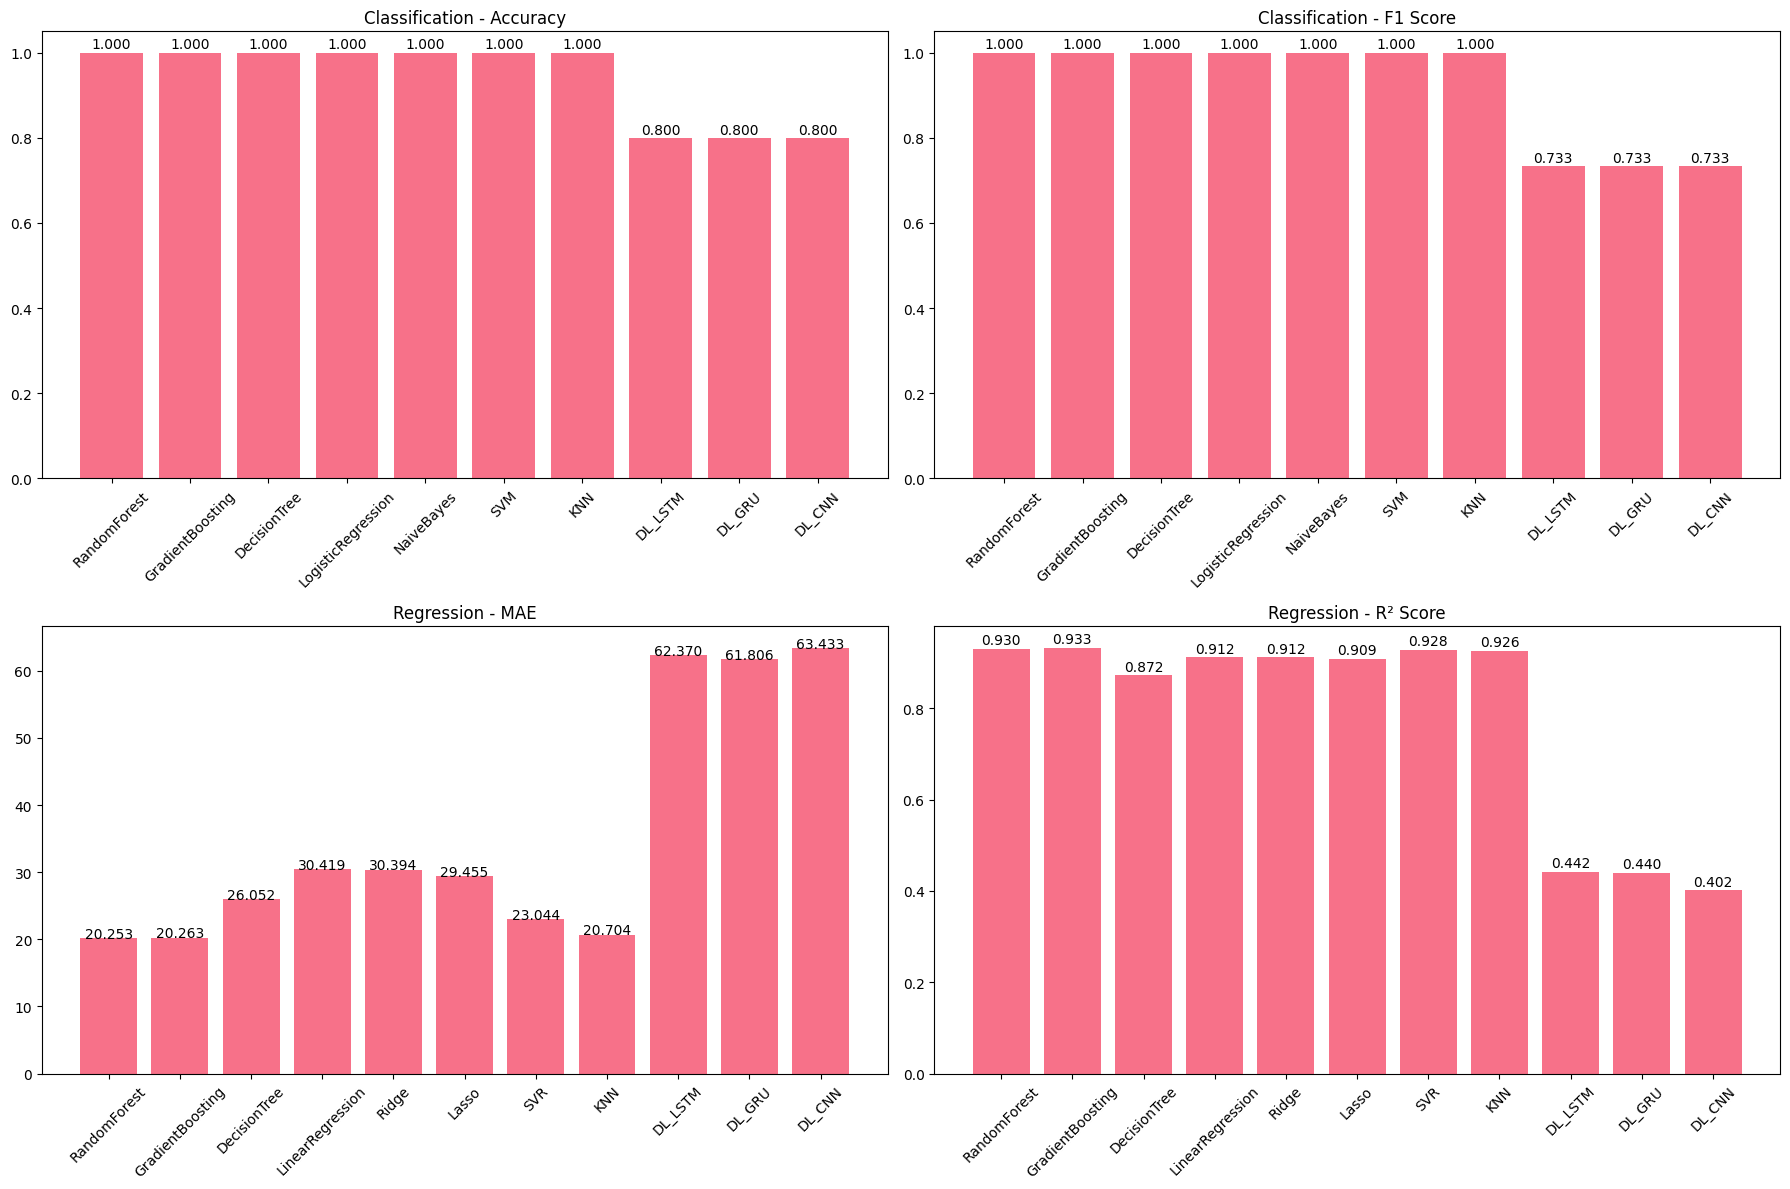


Best Models:
Model       GradientBoosting
MAE                20.262955
RMSE               38.406085
R2_Score            0.932905
Name: 1, dtype: object


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use('default')
sns.set_palette("husl")

# ---- Load Dataset ----
df = pd.read_csv("datasets/blade_dataset.csv")

# Features & Targets
X = df[["Vibration", "Torque", "Speed", "Noise", "Temp"]].values
y_cls = df["Condition"]
y_rul = df["RUL"]

# Encode classification labels
le = LabelEncoder()
y_cls = le.fit_transform(y_cls)

# ---- Alternate Row Split ----
X_train, X_test = X[::2], X[1::2]
y_cls_train, y_cls_test = y_cls[::2], y_cls[1::2]
y_rul_train, y_rul_test = y_rul[::2], y_rul[1::2]

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# For deep learning ‚Üí reshape
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Input shape: {X_train_seq.shape}")

# ---- Classical ML Models ----
classifiers = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(solver='svd'),
    "Lasso": Lasso(max_iter=10000),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# ---- Eval Functions ----
def evaluate_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds), f1_score(y_test, preds, average="weighted")

def evaluate_regressor(model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return (
            mean_absolute_error(y_test, preds),
            np.sqrt(mean_squared_error(y_test, preds)),
            r2_score(y_test, preds)
        )
    except Exception as e:
        print(f"Error with {model.__class__.__name__}: {e}")
        return np.nan, np.nan, np.nan

# ---- Compare Classical Models ----
results_cls, results_reg = [], []

print("\n=== Classical Models ===")
for name, clf in classifiers.items():
    acc, f1 = evaluate_classifier(clf, X_train, y_cls_train, X_test, y_cls_test)
    results_cls.append((name, acc, f1))
    print(f"[CLS] {name} ‚Üí Accuracy={acc:.3f}, F1={f1:.3f}")

for name, reg in regressors.items():
    mae, rmse, r2 = evaluate_regressor(reg, X_train, y_rul_train, X_test, y_rul_test)
    results_reg.append((name, mae, rmse, r2))
    print(f"[REG] {name} ‚Üí MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

# ---- Deep Learning Models ----
def build_lstm_classifier(shape, classes):
    m = Sequential([
        LSTM(64, input_shape=shape), Dropout(0.3),
        Dense(32, activation='relu'), Dropout(0.3),
        Dense(classes, activation="softmax")
    ])
    m.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    return m

def build_gru_classifier(shape, classes):
    m = Sequential([
        GRU(64, input_shape=shape), Dropout(0.3),
        Dense(32, activation='relu'), Dropout(0.3),
        Dense(classes, activation="softmax")
    ])
    m.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    return m

def build_cnn_classifier(shape, classes):
    m = Sequential([
        Conv1D(64, 3, activation="relu", input_shape=shape),
        MaxPooling1D(2), Flatten(),
        Dense(64, activation="relu"), Dropout(0.3),
        Dense(32, activation="relu"), Dropout(0.3),
        Dense(classes, activation="softmax")
    ])
    m.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    return m

def build_lstm_regressor(shape):
    m = Sequential([
        LSTM(64, input_shape=shape), Dropout(0.3),
        Dense(32, activation='relu'), Dropout(0.3),
        Dense(1)
    ])
    m.compile(loss="mse", optimizer=Adam(0.001), metrics=["mae"])
    return m

def build_gru_regressor(shape):
    m = Sequential([
        GRU(64, input_shape=shape), Dropout(0.3),
        Dense(32, activation='relu'), Dropout(0.3),
        Dense(1)
    ])
    m.compile(loss="mse", optimizer=Adam(0.001), metrics=["mae"])
    return m

def build_cnn_regressor(shape):
    m = Sequential([
        Conv1D(64, 3, activation="relu", input_shape=shape),
        MaxPooling1D(2), Flatten(),
        Dense(64, activation="relu"), Dropout(0.3),
        Dense(32, activation="relu"), Dropout(0.3),
        Dense(1)
    ])
    m.compile(loss="mse", optimizer=Adam(0.001), metrics=["mae"])
    return m

num_classes = len(np.unique(y_cls))
y_cls_train_cat = to_categorical(y_cls_train, num_classes=num_classes)
y_cls_test_cat = to_categorical(y_cls_test, num_classes=num_classes)

dl_classifiers = {
    "LSTM": build_lstm_classifier((X_train_seq.shape[1], 1), num_classes),
    "GRU": build_gru_classifier((X_train_seq.shape[1], 1), num_classes),
    "CNN": build_cnn_classifier((X_train_seq.shape[1], 1), num_classes)
}

dl_regressors = {
    "LSTM": build_lstm_regressor((X_train_seq.shape[1], 1)),
    "GRU": build_gru_regressor((X_train_seq.shape[1], 1)),
    "CNN": build_cnn_regressor((X_train_seq.shape[1], 1))
}

for name, model in dl_classifiers.items():
    print(f"Training DL_{name} classifier...")
    try:
        model.fit(X_train_seq, y_cls_train_cat, epochs=30, batch_size=16, verbose=0, validation_split=0.2)
        loss, acc = model.evaluate(X_test_seq, y_cls_test_cat, verbose=0)
        preds = model.predict(X_test_seq, verbose=0)
        preds_class = np.argmax(preds, axis=1)
        f1 = f1_score(y_cls_test, preds_class, average="weighted")
        results_cls.append((f"DL_{name}", acc, f1))
        print(f"[CLS] DL_{name} ‚Üí Accuracy={acc:.3f}, F1={f1:.3f}")
    except Exception as e:
        print(f"Error training DL_{name}: {e}")
        results_cls.append((f"DL_{name}", np.nan, np.nan))

for name, model in dl_regressors.items():
    print(f"Training DL_{name} regressor...")
    try:
        model.fit(X_train_seq, y_rul_train, epochs=30, batch_size=16, verbose=0, validation_split=0.2)
        preds = model.predict(X_test_seq, verbose=0).flatten()
        mae = mean_absolute_error(y_rul_test, preds)
        rmse = np.sqrt(mean_squared_error(y_rul_test, preds))
        r2 = r2_score(y_rul_test, preds)
        results_reg.append((f"DL_{name}", mae, rmse, r2))
        print(f"[REG] DL_{name} ‚Üí MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    except Exception as e:
        print(f"Error training DL_{name}: {e}")
        results_reg.append((f"DL_{name}", np.nan, np.nan, np.nan))

# ---- Plots ----
df_cls = pd.DataFrame(results_cls, columns=['Model', 'Accuracy', 'F1_Score']).dropna()
df_reg = pd.DataFrame(results_reg, columns=['Model', 'MAE', 'RMSE', 'R2_Score']).dropna()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Classification Accuracy
bars1 = axes[0, 0].bar(range(len(df_cls)), df_cls['Accuracy'])
axes[0, 0].set_title('Classification - Accuracy')
axes[0, 0].set_xticks(range(len(df_cls)))
axes[0, 0].set_xticklabels(df_cls['Model'], rotation=45)
for bar in bars1:
    axes[0, 0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"{bar.get_height():.3f}", ha="center")

# Classification F1
bars2 = axes[0, 1].bar(range(len(df_cls)), df_cls['F1_Score'])
axes[0, 1].set_title('Classification - F1 Score')
axes[0, 1].set_xticks(range(len(df_cls)))
axes[0, 1].set_xticklabels(df_cls['Model'], rotation=45)
for bar in bars2:
    axes[0, 1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"{bar.get_height():.3f}", ha="center")

# Regression MAE
bars3 = axes[1, 0].bar(range(len(df_reg)), df_reg['MAE'])
axes[1, 0].set_title('Regression - MAE')
axes[1, 0].set_xticks(range(len(df_reg)))
axes[1, 0].set_xticklabels(df_reg['Model'], rotation=45)
for bar in bars3:
    axes[1, 0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"{bar.get_height():.3f}", ha="center")

# Regression R2
bars4 = axes[1, 1].bar(range(len(df_reg)), df_reg['R2_Score'])
axes[1, 1].set_title('Regression - R¬≤ Score')
axes[1, 1].set_xticks(range(len(df_reg)))
axes[1, 1].set_xticklabels(df_reg['Model'], rotation=45)
for bar in bars4:
    axes[1, 1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"{bar.get_height():.3f}", ha="center")

plt.tight_layout()
plt.show()

# ---- Print Results ----
print("\nBest Models:")

if not df_reg.empty:
    print( df_reg.loc[df_reg['R2_Score'].idxmax()])

# Save results
df_cls.to_csv("blade_classification_results.csv", index=False)
df_reg.to_csv("blade_regression_results.csv", index=False)
